# In silico identification of switching nodes (ISIS), by F. Mairet
## <I>Escherichia coli</I> with various nutrient inputs

In [1]:
import cobra
model=cobra.io.read_sbml_model("iAF1260.xml")
from pandas import DataFrame
import pandas as pd
import numpy as np

### Computation of fluxes with pFBA

In [2]:
medium = model.medium
medium["EX_glc__D_e"] = 0.0
model.medium = medium

med=pd.read_excel('medium.xlsx', index_col=0) 

df1=DataFrame()

for i in range(1,175): 
    medium = model.medium
    if i>1:
        medium[med.at[i-1,'med']] = 0.0
    medium[med.at[i,'med']]=10.0
    model.medium = medium

    pfba_solution = cobra.flux_analysis.pfba(model)
    df1=pd.concat([df1, DataFrame(pfba_solution.fluxes)], axis = 1) 

df1.columns=med
df1.to_excel('Ecoli_Flux.xlsx', sheet_name='sheet1', index=False)

### Identification of switch nodes

In [3]:
# Concatenation and normalization of fluxes
V=df1.to_numpy()
V=np.divide(V,np.linalg.norm(V,axis=0))

S=cobra.util.array.create_stoichiometric_matrix(model,array_type='dense') # stoichiometric matrix

nm=S.shape[0] # number of metabolites

# loop on all the metabolites to compute their score
r=np.zeros(nm)
for i in range (0,nm):
    jj=S[i,:]!=0
    M=np.multiply(S[i,jj][np.newaxis,:].T, V[jj,:]) # compute M, removing the zero rows 
    
    u, s, vh = np.linalg.svd(M)
    
    if s[0]==0:
        r[i]=0
    else:
        r[i]=1-pow(s[0],2)/sum(pow(s,2))
        
# Export and print the results
df2=pd.concat([DataFrame(model.metabolites, columns=['Metabolite']), DataFrame(r, columns=['score'])], axis = 1) 
df2.to_excel('Ecoli_Metabolite.xlsx', sheet_name='sheet1', index=False)

ind=np.argsort(r)
for i in range (1,30):
    print(i,model.metabolites[ind[-i]].name,':',r[ind[-i]])

1 D-Fructose 6-phosphate : 0.5668183866700094
2 Glyoxylate : 0.5553485873198667
3 Phosphate : 0.5390815108877935
4 Pyruvate : 0.527632246878452
5 Maltose C12H22O11 : 0.5260732906462928
6 Acetyl-CoA : 0.5156188553964388
7 Glycine : 0.48707860205412423
8 Maltohexaose : 0.4805664651948809
9 Coenzyme A : 0.4740210825449287
10 L-Proline : 0.4547990685946035
11 Ammonium : 0.42793572830478366
12 Glycerol 3-phosphate : 0.3989354782218474
13 UMP C9H11N2O9P : 0.3964091801356383
14 Nicotinamide adenine dinucleotide phosphate - reduced : 0.39427906366573073
15 Nicotinamide adenine dinucleotide phosphate : 0.394279063469556
16 Xanthine : 0.35670329812584944
17 2-Deoxy-D-ribose 1-phosphate : 0.3565081528642433
18 D-Glucose 6-phosphate : 0.353699375918764
19 (R)-Glycerate : 0.34235710877375003
20 L-Serine : 0.33221272795890655
21 L-Lactaldehyde : 0.33157516871980464
22 D-Mannose 6-phosphate : 0.3308308279532385
23 L-Threonine : 0.3281801041391508
24 L-Glutamate : 0.3238511790918214
25 Alpha-D-Ribose 

### Check if switch nodes are ligand

In [4]:
lig=pd.read_excel('Ligands1.xlsx') # list of ligand (from Brunk et al., 2018)

ind=ind[::-1]  # indices from the highest to the lowest score
met=[]
r_met=[]
lig_met=[]
for i in ind:
    if not(model.metabolites[i].id[:-2] in met):
        met.append(model.metabolites[i].id[:-2] )  # add the metabolite in the list if it is not already in it
        r_met.append(r[i])
        if model.metabolites[i].id[:-2]  in lig.Name.tolist():   # check if it is a ligand
            lig_met.append(1)
        else :
            lig_met.append(0)
        
df3=pd.concat([DataFrame(met, columns = ['Metabolites']), DataFrame(r_met, columns = ['r']), DataFrame(lig_met, columns = ['ligand'])], axis = 1) 
df3.to_excel('MEtaboSwitchLig.xlsx', sheet_name='sheet1', index=False)

### Plot

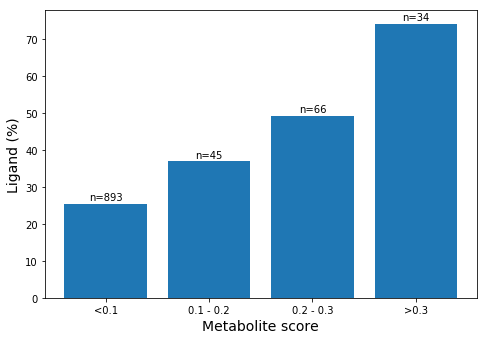

In [11]:
import matplotlib.pyplot as plt

def add_value_label(x_list,y_list,z_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1,y_list[i-1]+1,z_list[i-1], ha="center")
        
rmet=np.array(r_met)
ht=np.histogram(r_met, bins=[0, 0.1, 0.2, 0.3, 1])  # histogram of the metabolites depending on their score
h1=np.histogram(rmet[np.where(np.array(lig_met)>0)[0]], bins=[0, 0.1, 0.2, 0.3, 1]) # histogram of the metabolites which are ligands

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['<0.1', '0.1 - 0.2', '0.2 - 0.3', '>0.3']
numb=['n='+str(ht[0][0]),  'n='+str(ht[0][1]),  'n='+str(ht[0][2]),  'n='+str(ht[0][3])] 

ax.set_ylabel('Ligand (%)',fontsize=14)
ax.set_xlabel('Metabolite score',fontsize=14)
ax.bar(langs,100*h1[0] / ht[0]  )
add_value_label(langs,100*h1[0] / ht[0] ,numb  )

fig.savefig('ligand2.png', bbox_inches = 'tight')

    